# Web Scraping Project

### ที่มาและความสำคัญ

ร้านขายหนังสือออนไลน์สตาร์ทอัพต้องการเลือกสต็อกหนังสือที่มีแนวโน้มขายดีตามแนวโน้มของตลาดในปัจจุบัน เป้าหมายคือการเพิ่มผลตอบแทนจากการลงทุนเบื้องต้น

# ขั้นตอนที่ 1 การดึงข้อมูลจาก (WebScraping)

In [37]:
# Import necessary libraries
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
import pandas as pd
import re

# Variable to store website link as string
myurl = 'http://books.toscrape.com/catalogue/page-{}.html'
base_url = 'http://books.toscrape.com/catalogue/'

# Create empty lists to store book details (define them outside the loop)
book_titles = []
book_prices = []
book_genre = []
book_rating = []
book_Stock_Status = []
book_reviews = []
book_available = []

# Loop through pages 1 to 50
for i in range(1, 51):
    # Grab website and store in variable uclient
    uClient = uReq(myurl.format(i))

    # Read and close HTML
    page_html = uClient.read()
    uClient.close()

    # Call BeautifulSoup for parsing
    page_soup = soup(page_html, "html.parser")

    # Grabs all the products under list tag
    bookshelf = page_soup.findAll("li", {"class": "col-xs-6 col-sm-4 col-md-3 col-lg-3"})

    for books in bookshelf:
        # Collect title of all books
        book_title = books.h3.a["title"]

        # Collect book price of all books
        book_price = books.findAll("p", {"class": "price_color"})
        price = book_price[0].text.strip()

        # Collect genre of all books
        url_book_genre_parser = books.h3.a["href"]
        full_url_book_genre_parser = base_url + url_book_genre_parser.replace("../", "")  # Create the full URL

        # Open the book's page and parse it
        uClient_genre = uReq(full_url_book_genre_parser)
        url_page = uClient_genre.read()
        uClient_genre.close()

        # Call BeautifulSoup for parsing
        url_soup = soup(url_page, "html.parser")

        # Initialize genre with a default value in case breadcrumb is not found
        genre = "Unknown"

        # Grabs the product's genre
        breadcrumb = url_soup.find("ul", {"class": "breadcrumb"})
        if breadcrumb:
            genre = breadcrumb.findAll("li")[2].a.text.strip()

        # Find the number of reviews in the table
        book_reviews_count = "N/A"  # Default value if not found
        reviews_count = url_soup.find("table", {"class": "table table-striped"})
        if reviews_count:
            reviews_th = reviews_count.find("th", string="Number of reviews")
            if reviews_th:
                book_reviews_count = reviews_th.find_next_sibling("td").text.strip()

        # Find the availability in the table (replace 'url_soup' with your actual soup object)
        reviews_count = url_soup.find("table", {"class": "table table-striped"})
        if reviews_count:
            reviews_th = reviews_count.find("th", string="Availability")
            if reviews_th:
                availability_text = reviews_th.find_next_sibling("td").text.strip()

                # Extract the number of available stock using regex
                match = re.search(r'\((\d+)\savailable\)', availability_text)
                if match:
                    available_count = match.group(1)  # Extract the number (22)
                    book_available.append(int(available_count))  # Append the available count to the list

        # Get book rating
        book_star = books.p["class"][1].lower()
        if book_star == "one":
            rating = 1
        elif book_star == "two":
            rating = 2
        elif book_star == "three":
            rating = 3
        elif book_star == "four":
            rating = 4
        else:
            rating = 5

        # Get stock status
        book_Status = books.find("div", {"class": "product_price"})
        book_Stock = "N/A"  # Default value
        if book_Status:
            stock_info = book_Status.find("p", {"class": "instock availability"})
            if stock_info:
                book_Stock = stock_info.text.strip()

        # Append the collected data to lists
        book_titles.append(book_title)
        book_prices.append(price)
        book_genre.append(genre)
        book_rating.append(rating)
        book_Stock_Status.append(book_Stock)
        book_reviews.append(book_reviews_count)

# Create a pandas DataFrame to hold the collected data, including available stock
books_df = pd.DataFrame({
    'Genre': book_genre,
    'Book Title': book_titles,
    'Price': book_prices,
    'Rating': book_rating,
    'Stock Status': book_Stock_Status,
    'Number of Reviews': book_reviews,
    'Available Stock': book_available  # Add the available stock to the DataFrame
})

# Save the dataframe as a CSV file
books_df.to_csv("Books.csv", index=False)

# Display the dataframe
print(books_df)


                 Genre                                         Book Title  \
0               Poetry                               A Light in the Attic   
1   Historical Fiction                                 Tipping the Velvet   
2              Fiction                                         Soumission   
3              Mystery                                      Sharp Objects   
4              History              Sapiens: A Brief History of Humankind   
5          Young Adult                                    The Requiem Red   
6             Business  The Dirty Little Secrets of Getting Your Dream...   
7              Default  The Coming Woman: A Novel Based on the Life of...   
8              Default  The Boys in the Boat: Nine Americans and Their...   
9               Poetry                                    The Black Maria   
10             Default     Starving Hearts (Triangular Trade Trilogy, #1)   
11              Poetry                              Shakespeare's Sonnets   

# ขั้นตอนที่ 2 ทำความสะอาดข้อมูล (Data Cleaning and Preparation)

In [28]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('Books.csv')

# Drop rows with NaN values
df = df.dropna()

# Remove the '£' symbol and convert 'Price' column to numeric
df['Price'] = df['Price'].str.replace('£', '').astype(float)

# Calculate IQR to remove outliers
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
filter = (df['Price'] >= Q1 - 1.5 * IQR) & (df['Price'] <= Q3 + 1.5 * IQR)
df_cleaned = df.loc[filter]

# Sort the cleaned DataFrame by 'Price' in ascending order
df_cleaned_sorted = df_cleaned.sort_values(by='Price', ascending=False)

# Display the cleaned DataFrame
print(df_cleaned_sorted)


              Genre                                         Book Title  Price  \
648         Romance                 The Perfect Play (Play by Play #1)  59.99   
617         Fiction                  Last One Home (New Beginnings #1)  59.98   
860      Psychology                   Civilization and Its Discontents  59.95   
560  Food and Drink                     The Barefoot Contessa Cookbook  59.92   
366      Nonfiction                          The Diary of a Young Girl  59.90   
..              ...                                                ...    ...   
302         Default                               Greek Mythic History  10.23   
84   Sequential Art                                           Patience  10.16   
716   Add a comment  The Tipping Point: How Little Things Can Make ...  10.02   
501         Science                              The Origin of Species  10.01   
638     Young Adult                         An Abundance of Katherines  10.00   

     Rating Stock Status  N

# ขั้นตอนที่ 3 การวิเคราะห์ข้อมูล (Data Analysis)

In [9]:
# Group by 'Genre' and calculate the mean of 'Price'
mean_price_by_genre = df.groupby('Genre')['Price'].mean().sort_values(ascending=True)
print(mean_price_by_genre)

Genre
Crime                 10.970000
Academic              13.120000
Adult Fiction         15.360000
Paranormal            15.400000
Erotica               19.190000
Historical            22.830000
Food and Drink        31.414667
Thriller              31.433636
Mystery               31.719062
Business              32.460000
Religion              32.567143
Childrens             32.638276
Science               33.088571
Humor                 33.501000
Philosophy            33.558182
Historical Fiction    33.644231
Biography             33.662000
Science Fiction       33.802500
Romance               33.933714
Psychology            34.218571
Nonfiction            34.260182
Christian Fiction     34.385000
Default               34.392697
Sequential Art        34.572267
Spirituality          35.098333
Young Adult           35.449074
Music                 35.636923
Add a comment         35.796418
Short Stories         35.880000
Horror                35.949412
Poetry                35.974211
Fi

In [26]:
# Group by 'Genre' and calculate the count of books in each genre
book_count_by_genre = df.groupby('Genre').size()
# Filter genres that have more than 10 books
genres_with_more_than_10_books = book_count_by_genre[book_count_by_genre > 10].index

# Filter the mean price by these genres
mean_price_by_genre = df[df['Genre'].isin(genres_with_more_than_10_books)].groupby('Genre')['Price'].mean().sort_values(ascending=True)
print(mean_price_by_genre)

Genre
Food and Drink        31.414667
Thriller              31.433636
Mystery               31.719062
Business              32.460000
Childrens             32.638276
Science               33.088571
Philosophy            33.558182
Historical Fiction    33.644231
Science Fiction       33.802500
Romance               33.933714
Nonfiction            34.260182
Default               34.392697
Sequential Art        34.572267
Young Adult           35.449074
Music                 35.636923
Add a comment         35.796418
Horror                35.949412
Poetry                35.974211
Fiction               36.066615
Classics              36.545263
Womens Fiction        36.791176
History               37.295000
Fantasy               39.593958
Travel                39.794545
Name: Price, dtype: float64


In [10]:
# Group by 'Genre' and calculate the mean of 'Rating'
mean_rating_by_genre = df.groupby('Genre')['Rating'].mean().sort_values(ascending=False)
print(mean_rating_by_genre)

Genre
Erotica               5.000000
Adult Fiction         5.000000
Novels                5.000000
Christian Fiction     4.166667
Health                3.750000
Art                   3.625000
Poetry                3.526316
Humor                 3.400000
Spirituality          3.333333
Young Adult           3.296296
Historical Fiction    3.230769
Fiction               3.184615
New Adult             3.166667
Music                 3.153846
Religion              3.142857
Womens Fiction        3.117647
Fantasy               3.083333
Historical            3.000000
Autobiography         3.000000
Sports and Games      3.000000
Suspense              3.000000
Sequential Art        2.973333
History               2.944444
Mystery               2.937500
Science               2.928571
Business              2.916667
Food and Drink        2.900000
Nonfiction            2.881818
Default               2.835526
Add a comment         2.761194
Thriller              2.727273
Travel                2.727273
Ho

In [11]:
# Calculate the average price of all books
average_price_all_books = df['Price'].mean()
print(f"Average price of all books: {average_price_all_books}")

Average price of all books: 35.07035


In [12]:
# Group by 'Genre' and calculate the min and max prices for each genre
price_min_max_per_genre = df.groupby('Genre')['Price'].agg(['min', 'max']).reset_index()
price_min_max_per_genre.columns = ['Genre', 'Price Min', 'Price Max']
print(price_min_max_per_genre)

                 Genre  Price Min  Price Max
0             Academic      13.12      13.12
1        Add a comment      10.02      59.15
2        Adult Fiction      15.36      15.36
3                  Art      10.29      49.05
4        Autobiography      10.93      59.04
5            Biography      16.85      48.19
6             Business      12.61      51.74
7            Childrens      10.62      58.08
8            Christian      25.77      54.00
9    Christian Fiction      17.97      49.97
10            Classics      14.82      58.63
11        Contemporary      24.04      52.79
12               Crime      10.97      10.97
13            Cultural      36.58      36.58
14             Default      10.23      58.87
15             Erotica      19.19      19.19
16             Fantasy      12.16      58.75
17             Fiction      10.60      59.98
18      Food and Drink      11.05      59.92
19              Health      49.05      54.07
20          Historical      15.79      29.87
21  Histor

In [13]:
# Create a new column 'In Stock' where 'In stock' is assigned 1, otherwise 0
df['In Stock'] = df['Stock Status'].apply(lambda x: 1 if x == 'In stock' else 0)
# Group by 'Genre' and calculate the sum of 'In Stock' to see how many books are in stock per genre
in_stock_per_genre = df.groupby('Genre')['In Stock'].sum().reset_index()
print(in_stock_per_genre)

                 Genre  In Stock
0             Academic         1
1        Add a comment        67
2        Adult Fiction         1
3                  Art         8
4        Autobiography         9
5            Biography         5
6             Business        12
7            Childrens        29
8            Christian         3
9    Christian Fiction         6
10            Classics        19
11        Contemporary         3
12               Crime         1
13            Cultural         1
14             Default       152
15             Erotica         1
16             Fantasy        48
17             Fiction        65
18      Food and Drink        30
19              Health         4
20          Historical         2
21  Historical Fiction        26
22             History        18
23              Horror        17
24               Humor        10
25               Music        13
26             Mystery        32
27           New Adult         6
28          Nonfiction       110
29        

In [65]:
# Step 1: Group by 'Genre' and calculate the number of books and total available stock
genre_stats = df.groupby('Genre').agg(
    num_books=('Book Title', 'count'),           # Number of books in each genre
    total_available_stock=('Available Stock', 'sum')  # Total available stock in each genre
).reset_index()

# Calculate the stock ratio (available stock / number of books)
genre_stats['stock_ratio'] = genre_stats['total_available_stock'] / genre_stats['num_books']
# Sort by 'stock_ratio' in ascending order
genre_stats_sorted = genre_stats.sort_values(by='stock_ratio', ascending=True)

# Display the sorted DataFrame
print(genre_stats_sorted)

                 Genre  num_books  total_available_stock  stock_ratio
30          Paranormal          1                      1     1.000000
44    Sports and Games          5                     10     2.000000
10            Classics         19                     55     2.894737
2        Adult Fiction          1                      3     3.000000
31           Parenting          1                      3     3.000000
0             Academic          1                      5     5.000000
48      Womens Fiction         17                     91     5.352941
4        Autobiography          9                     57     6.333333
35          Psychology          7                     52     7.428571
32          Philosophy         11                     82     7.454545
21  Historical Fiction         26                    194     7.461538
38             Science         14                    105     7.500000
37             Romance         35                    269     7.685714
1        Add a comme

In [57]:
# Check if the 'Price' column contains strings before replacing the '£' symbol
if df['Price'].dtype == 'object':
    df['Price'] = df['Price'].str.replace('£', '').astype(float)
else:
    df['Price'] = df['Price'].astype(float)

# Group by 'Genre' to calculate average price, minimum price, and maximum price for each genre
pricing_trends_by_genre = df.groupby('Genre').agg(
    avg_price=('Price', 'mean'),        # Average price for each genre
    min_price=('Price', 'min'),         # Minimum price for each genre
    max_price=('Price', 'max')          # Maximum price for each genre
).reset_index()

# Sort by average price to see the distribution of prices across genres
pricing_trends_sorted = pricing_trends_by_genre.sort_values(by='avg_price', ascending=False)

# Display the sorted results
pricing_trends_sorted

,Genre,avg_price,min_price,max_price
45,Suspense,58.330000,58.33,58.33
29,Novels,54.810000,54.81,54.81
34,Politics,53.613333,51.33,56.86
19,Health,51.452500,49.05,54.07
27,New Adult,46.383333,36.29,58.35
8,Christian,42.496667,25.77,54.00
44,Sports and Games,41.166000,24.42,51.22
40,Self Help,40.620000,12.08,52.15
47,Travel,39.794545,23.21,56.88
16,Fantasy,39.593958,12.16,58.75


# ขั้นตอนที่ 4 การสร้างภาพข้อมูล (Visualization)

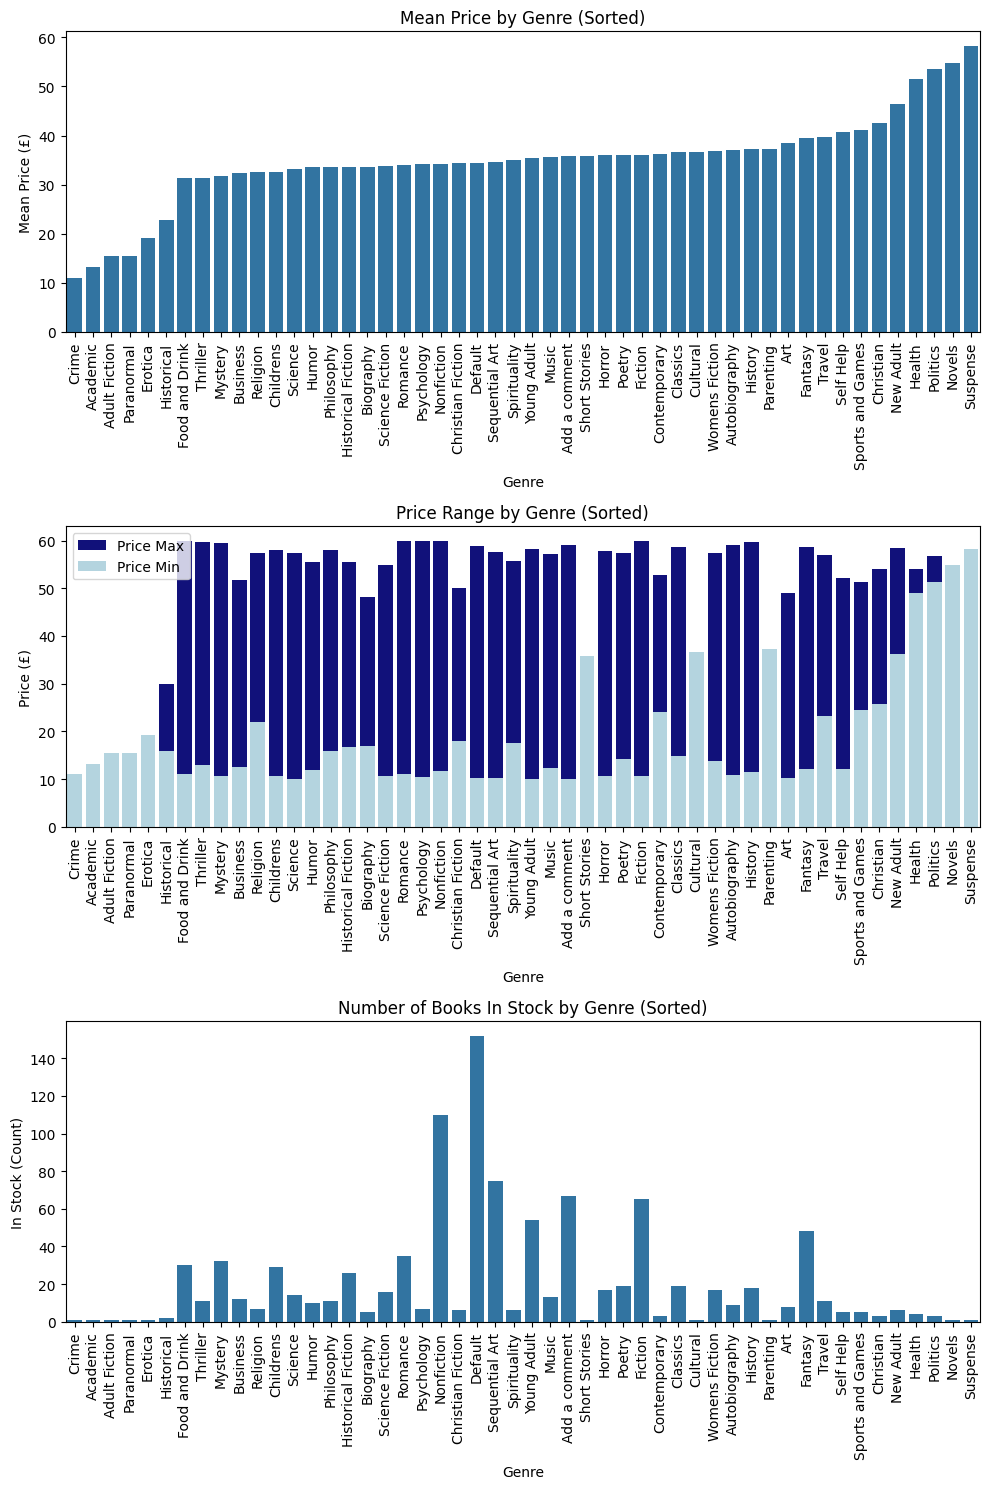

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'Genre' and calculate the mean of 'Price'
mean_price_by_genre = df.groupby('Genre')['Price'].mean().sort_values(ascending=True)

# Group by 'Genre' and calculate the min and max prices for each genre
price_min_max_per_genre = df.groupby('Genre')['Price'].agg(['min', 'max']).reset_index()
price_min_max_per_genre.columns = ['Genre', 'Price Min', 'Price Max']

# Create a new column 'In Stock' where 'In stock' is assigned 1, otherwise 0
df['In Stock'] = df['Stock Status'].apply(lambda x: 1 if x == 'In stock' else 0)

# Group by 'Genre' and calculate the sum of 'In Stock' to see how many books are in stock per genre
in_stock_per_genre = df.groupby('Genre')['In Stock'].sum().reset_index()

# Merge all the calculated data into a single DataFrame for visualization
merged_data = pd.merge(price_min_max_per_genre, in_stock_per_genre, on='Genre')
merged_data['Mean Price'] = df.groupby('Genre')['Price'].mean().values

# Sort the merged data by 'Mean Price' in ascending order
merged_data = merged_data.sort_values(by='Mean Price', ascending=True)

# Plot the data
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot the mean price by genre (sorted by Mean Price)
sns.barplot(x='Genre', y='Mean Price', data=merged_data, ax=axes[0])
axes[0].set_title('Mean Price by Genre (Sorted)')
axes[0].set_ylabel('Mean Price (£)')
axes[0].set_xlabel('Genre')
axes[0].tick_params(axis='x', rotation=90)

# Plot the price range (min and max) by genre
sns.barplot(x='Genre', y='Price Max', data=merged_data, ax=axes[1], color='darkblue', label='Price Max')
sns.barplot(x='Genre', y='Price Min', data=merged_data, ax=axes[1], color='lightblue', label='Price Min')
axes[1].set_title('Price Range by Genre (Sorted)')
axes[1].set_ylabel('Price (£)')
axes[1].set_xlabel('Genre')
axes[1].tick_params(axis='x', rotation=90)
axes[1].legend()

# Plot the number of books in stock by genre
sns.barplot(x='Genre', y='In Stock', data=merged_data, ax=axes[2])
axes[2].set_title('Number of Books In Stock by Genre (Sorted)')
axes[2].set_ylabel('In Stock (Count)')
axes[2].set_xlabel('Genre')
axes[2].tick_params(axis='x', rotation=90)

# Display the plots
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_21452\547175979.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_rating', y='Genre', data=ratings_reviews_by_genre_sorted, palette='coolwarm')


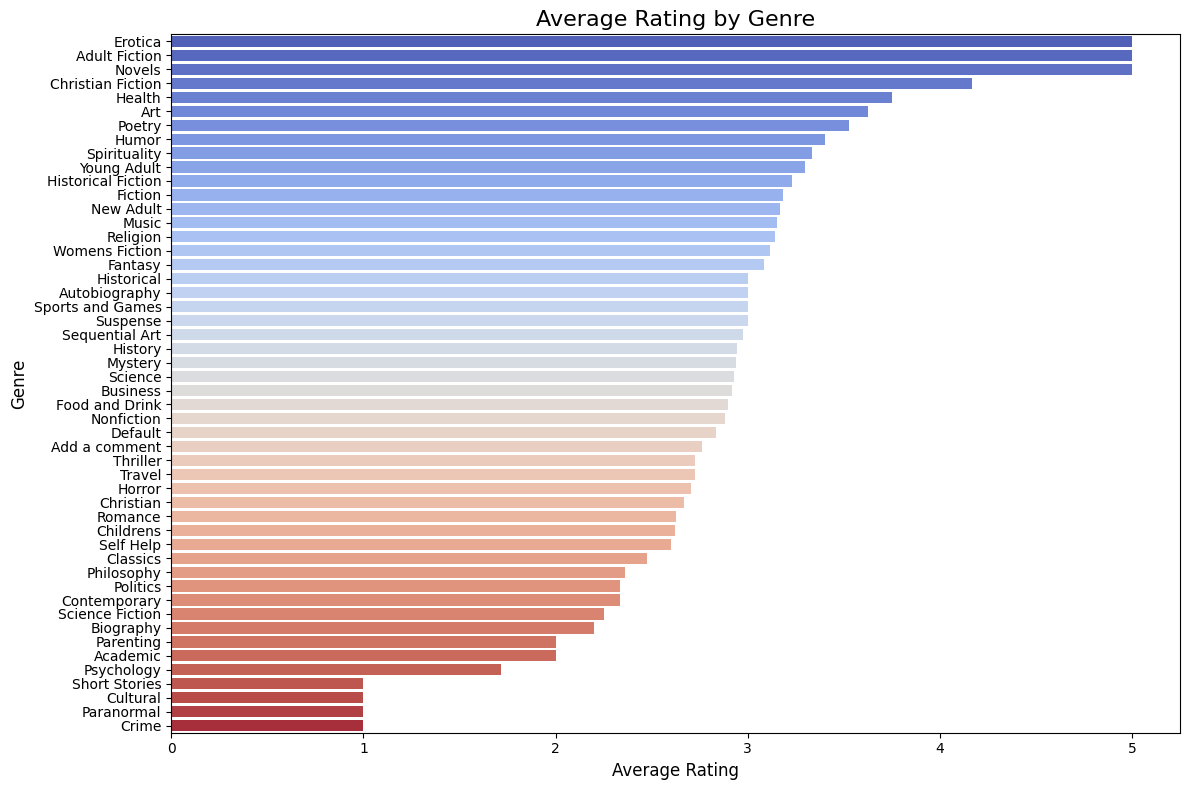

In [50]:
ratings_reviews_by_genre = df.groupby('Genre').agg(
    avg_rating=('Rating', 'mean'),       # Average rating for each genre
    total_reviews=('Number of Reviews', 'sum')  # Total number of reviews for each genre
).reset_index()

# Sort by average rating
ratings_reviews_by_genre_sorted = ratings_reviews_by_genre.sort_values(by='avg_rating', ascending=False)

# Set up the plot with a larger figure size to display all genres
plt.figure(figsize=(12, 8))

# Create a barplot showing the average rating by genre
sns.barplot(x='avg_rating', y='Genre', data=ratings_reviews_by_genre_sorted, palette='coolwarm')

# Add labels and title
plt.title('Average Rating by Genre', fontsize=16)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Genre', fontsize=12)

# Adjust the layout to ensure all genres are displayed
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_21452\279774006.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_rating', y='Genre', data=ratings_reviews_by_genre_sorted, palette='coolwarm')


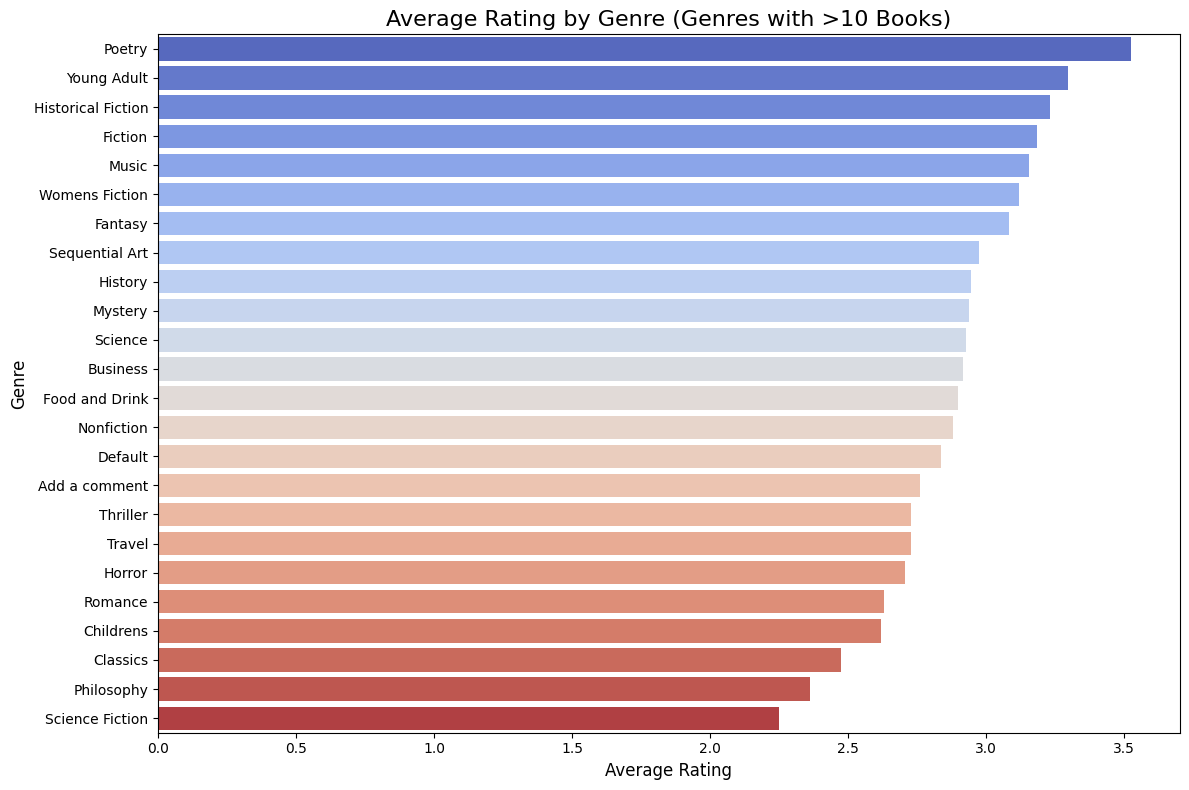

In [51]:
# Group by 'Genre' to calculate average rating, total number of reviews, and count of books
ratings_reviews_by_genre = df.groupby('Genre').agg(
    avg_rating=('Rating', 'mean'),        # Average rating for each genre
    total_reviews=('Number of Reviews', 'sum'),  # Total number of reviews for each genre
    book_count=('Book Title', 'count')    # Number of books in each genre
).reset_index()

# Filter genres that have more than 10 books
ratings_reviews_by_genre_filtered = ratings_reviews_by_genre[ratings_reviews_by_genre['book_count'] > 10]

# Sort by average rating
ratings_reviews_by_genre_sorted = ratings_reviews_by_genre_filtered.sort_values(by='avg_rating', ascending=False)

# Set up the plot with a larger figure size to display all genres
plt.figure(figsize=(12, 8))

# Create a barplot showing the average rating by genre
sns.barplot(x='avg_rating', y='Genre', data=ratings_reviews_by_genre_sorted, palette='coolwarm')

# Add labels and title
plt.title('Average Rating by Genre (Genres with >10 Books)', fontsize=16)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Genre', fontsize=12)

# Adjust the layout to ensure all genres are displayed
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_21452\4260330193.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Genre', y='Mean Price', data=merged_data, palette='Blues_d')


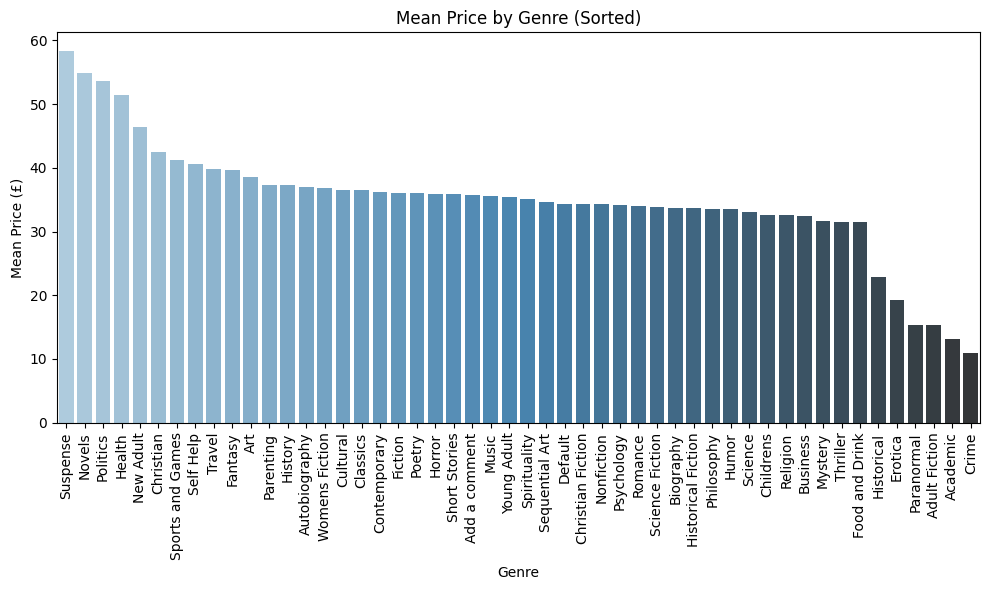

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'Genre' and calculate the mean of 'Price'
mean_price_by_genre = df.groupby('Genre')['Price'].mean().sort_values(ascending=False)

# Group by 'Genre' and calculate the min and max prices for each genre
price_min_max_per_genre = df.groupby('Genre')['Price'].agg(['min', 'max']).reset_index()
price_min_max_per_genre.columns = ['Genre', 'Price Min', 'Price Max']

# Create a new column 'In Stock' where 'In stock' is assigned 1, otherwise 0
df['In Stock'] = df['Stock Status'].apply(lambda x: 1 if x == 'In stock' else 0)

# Group by 'Genre' and calculate the sum of 'In Stock' to see how many books are in stock per genre
in_stock_per_genre = df.groupby('Genre')['In Stock'].sum().reset_index()

# Merge all the calculated data into a single DataFrame for visualization
merged_data = pd.merge(price_min_max_per_genre, in_stock_per_genre, on='Genre')
merged_data['Mean Price'] = df.groupby('Genre')['Price'].mean().values

# Sort the merged data by 'Mean Price' in ascending order
merged_data = merged_data.sort_values(by='Mean Price', ascending=False)

# Plot the mean price by genre (sorted by Mean Price)
plt.figure(figsize=(10, 6))
sns.barplot(x='Genre', y='Mean Price', data=merged_data, palette='Blues_d')

# Add titles and labels
plt.title('Mean Price by Genre (Sorted)')
plt.ylabel('Mean Price (£)')
plt.xlabel('Genre')

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_21452\3564754019.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Genre', y='Mean Price', data=merged_data, palette='Blues_d')


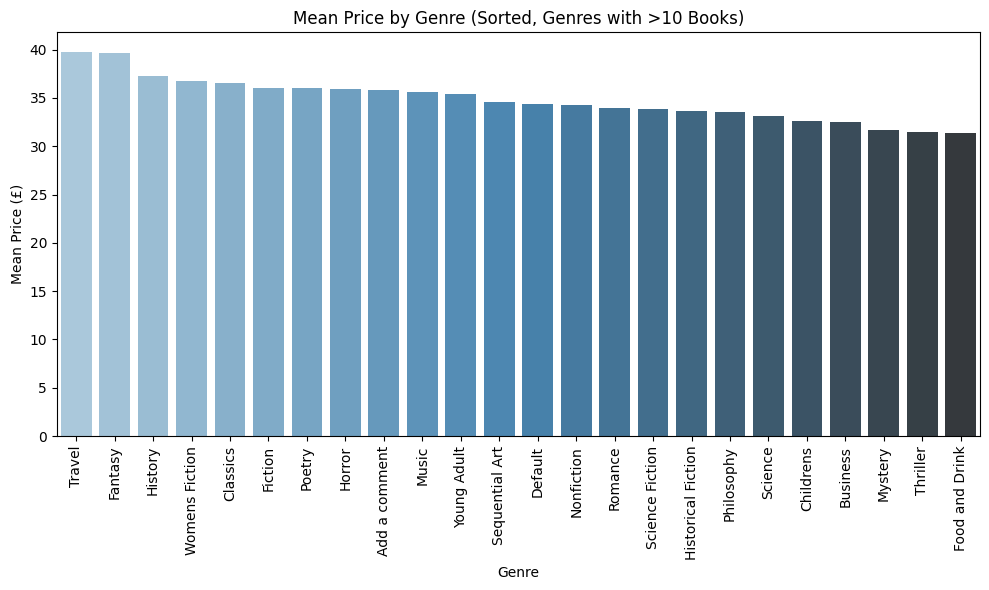

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'Genre' and calculate the mean of 'Price'
mean_price_by_genre = df.groupby('Genre')['Price'].mean().sort_values(ascending=False)

# Group by 'Genre' and calculate the min and max prices for each genre
price_min_max_per_genre = df.groupby('Genre')['Price'].agg(['min', 'max']).reset_index()
price_min_max_per_genre.columns = ['Genre', 'Price Min', 'Price Max']

# Create a new column 'In Stock' where 'In stock' is assigned 1, otherwise 0
df['In Stock'] = df['Stock Status'].apply(lambda x: 1 if x == 'In stock' else 0)

# Group by 'Genre' and calculate the sum of 'In Stock' to see how many books are in stock per genre
in_stock_per_genre = df.groupby('Genre')['In Stock'].sum().reset_index()

# Count the number of books in each genre
book_count_per_genre = df.groupby('Genre')['Book Title'].count().reset_index()
book_count_per_genre.columns = ['Genre', 'Book Count']

# Filter only genres with more than 10 books
book_count_per_genre = book_count_per_genre[book_count_per_genre['Book Count'] > 10]

# Merge all the calculated data into a single DataFrame for visualization
merged_data = pd.merge(price_min_max_per_genre, in_stock_per_genre, on='Genre')
merged_data['Mean Price'] = df.groupby('Genre')['Price'].mean().values

# Merge with the book count to filter only genres with more than 10 books
merged_data = pd.merge(merged_data, book_count_per_genre, on='Genre')

# Sort the merged data by 'Mean Price' in descending order
merged_data = merged_data.sort_values(by='Mean Price', ascending=False)

# Plot the mean price by genre (sorted by Mean Price)
plt.figure(figsize=(10, 6))
sns.barplot(x='Genre', y='Mean Price', data=merged_data, palette='Blues_d')

# Add titles and labels
plt.title('Mean Price by Genre (Sorted, Genres with >10 Books)')
plt.ylabel('Mean Price (£)')
plt.xlabel('Genre')

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_21452\4074213437.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='stock_ratio', y='Genre', data=genre_stats_sorted, palette='viridis')


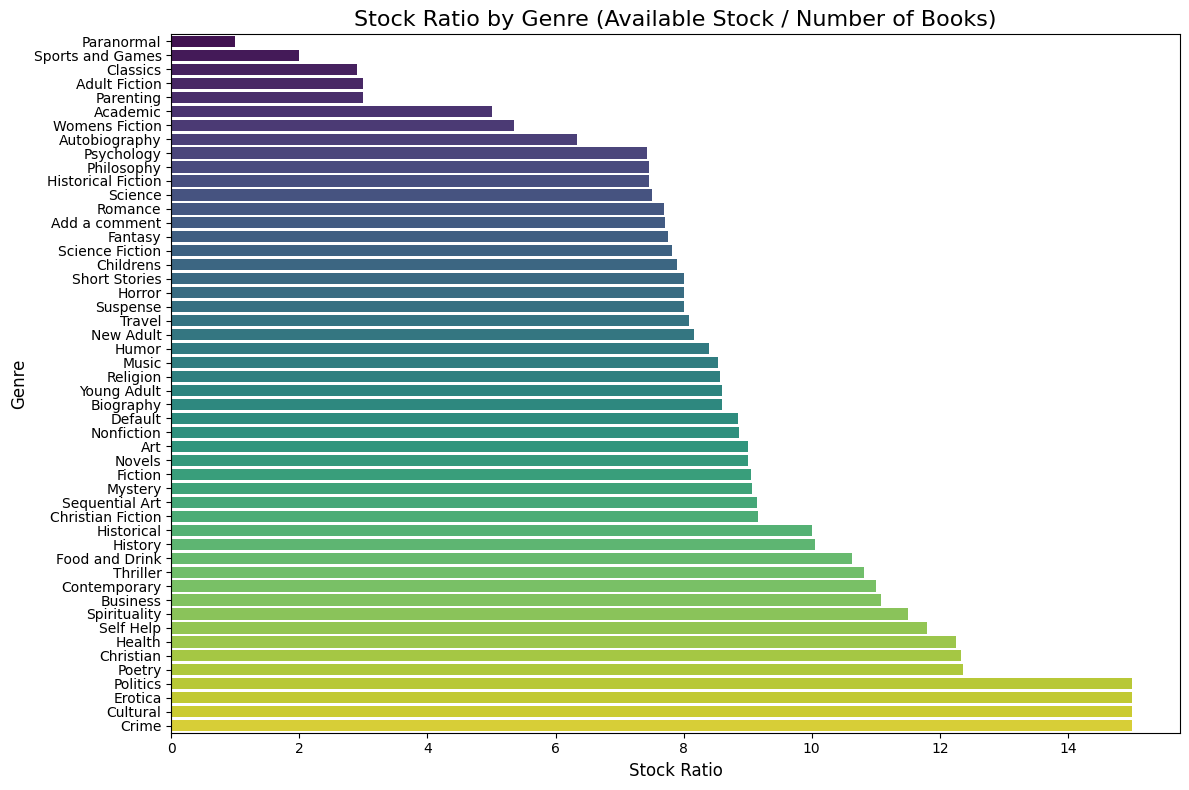

In [66]:
# Plot the stock ratio by genre
plt.figure(figsize=(12, 8))
sns.barplot(x='stock_ratio', y='Genre', data=genre_stats_sorted, palette='viridis')

# Add titles and labels
plt.title('Stock Ratio by Genre (Available Stock / Number of Books)', fontsize=16)
plt.xlabel('Stock Ratio', fontsize=12)
plt.ylabel('Genre', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_21452\3174712294.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='stock_ratio', y='Genre', data=filtered_genre_stats, palette='viridis')


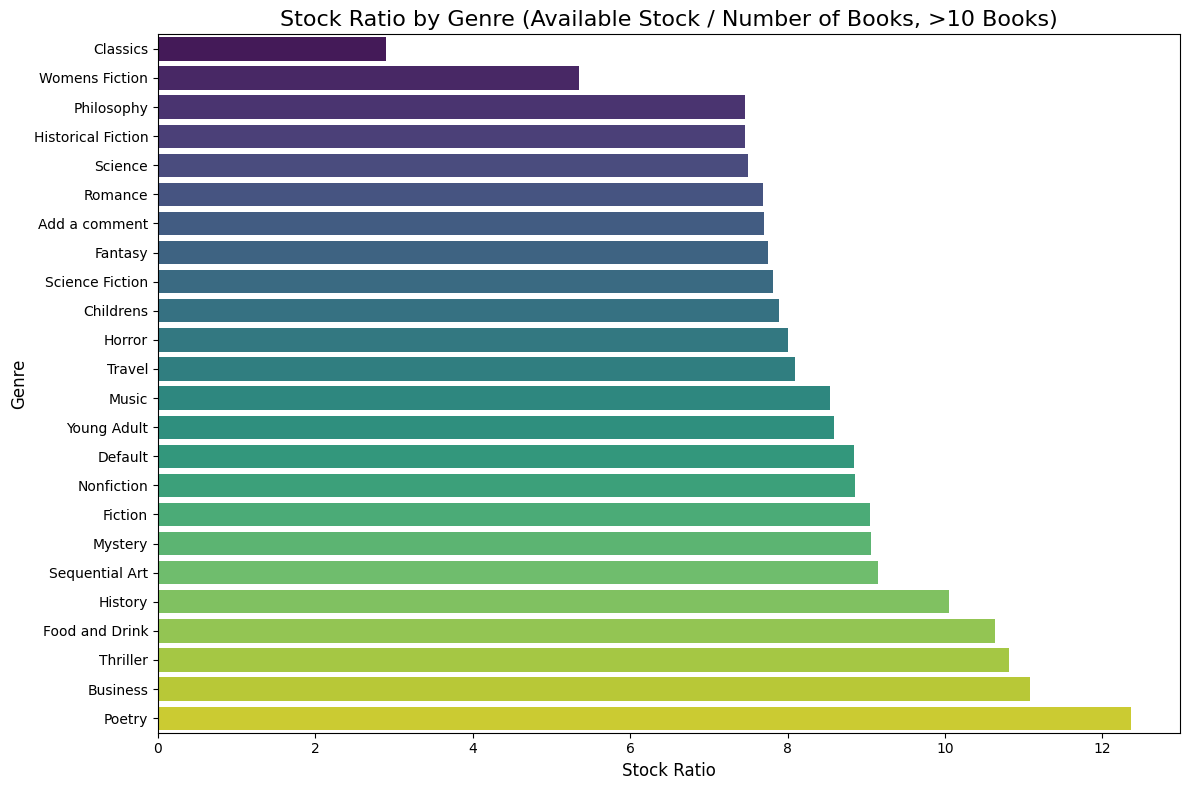

In [67]:
# Filter genres that have more than 10 books
filtered_genre_stats = genre_stats_sorted[genre_stats_sorted['num_books'] > 10]

# Plot the stock ratio by genre (only for genres with more than 10 books)
plt.figure(figsize=(12, 8))
sns.barplot(x='stock_ratio', y='Genre', data=filtered_genre_stats, palette='viridis')

# Add titles and labels
plt.title('Stock Ratio by Genre (Available Stock / Number of Books, >10 Books)', fontsize=16)
plt.xlabel('Stock Ratio', fontsize=12)
plt.ylabel('Genre', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


## รายชื่อสมาชิกในกลุ่ม
| ลาดับ | ชื่อ | รหัสนิสิต |
|--------|-------------|------------------|
| 1 | อติพล เดชาติวงศ์ ณ อยุธยา | 65109010307 |
| 2 | กฤษณะ สุขจร | 65109010286 |
| 2 | ปุญญาพัฒน์ จันทะคุณ | 65109010299 |